# **Analyse des résultats du décoding neural**
_Alexandre Lainé ~ 2023/10/11_

In [2]:
# Importation des modules important
import numpy as np
import matplotlib.pyplot as plt
import params as p
import scipy.stats as stt
from sklearn.linear_model import LinearRegression as lm
from sklearn.metrics import r2_score as r2
import os

In [3]:
# Chemin utilisable
path = os.getcwd()

# Nécessaire d'utilisation
decoding_type = ["decod_theta","decod_btheta","decod_combinaison"]
transformation_type = ["origin","equalize","erfinv"]
data_type = ["Score_mean","Score_sd"]

# Charte graphique
colors = ["black", "red", "purple"]
colors_fill = ["grey", "tomato", "violet"]
legends = ["firing rate", "egal", "probit"]

In [4]:
# Chargement des données 
Score_decod_theta = np.zeros((len(p.timesteps),8, 3,2))
Score_decod_btheta = np.zeros((len(p.timesteps),3,2))
Score_decod_combinaison = np.zeros((len(p.timesteps),3,2))

for i,transfo_type in enumerate(transformation_type):
    for j,d_type in enumerate(data_type):
        Score_decod_theta[:,:,i,j] = np.load(os.path.join(path, "data", "Stage", decoding_type[0], transfo_type, f"{d_type}.npy"))
        Score_decod_btheta[:,i,j] = np.load(os.path.join(path, "data", "Stage", decoding_type[1], transfo_type, f"{d_type}.npy"))
        Score_decod_combinaison[:,i,j] = np.load(os.path.join(path, "data", "Stage", decoding_type[2], transfo_type, f"{d_type}.npy"))

## Résumé des résultats avant analyse

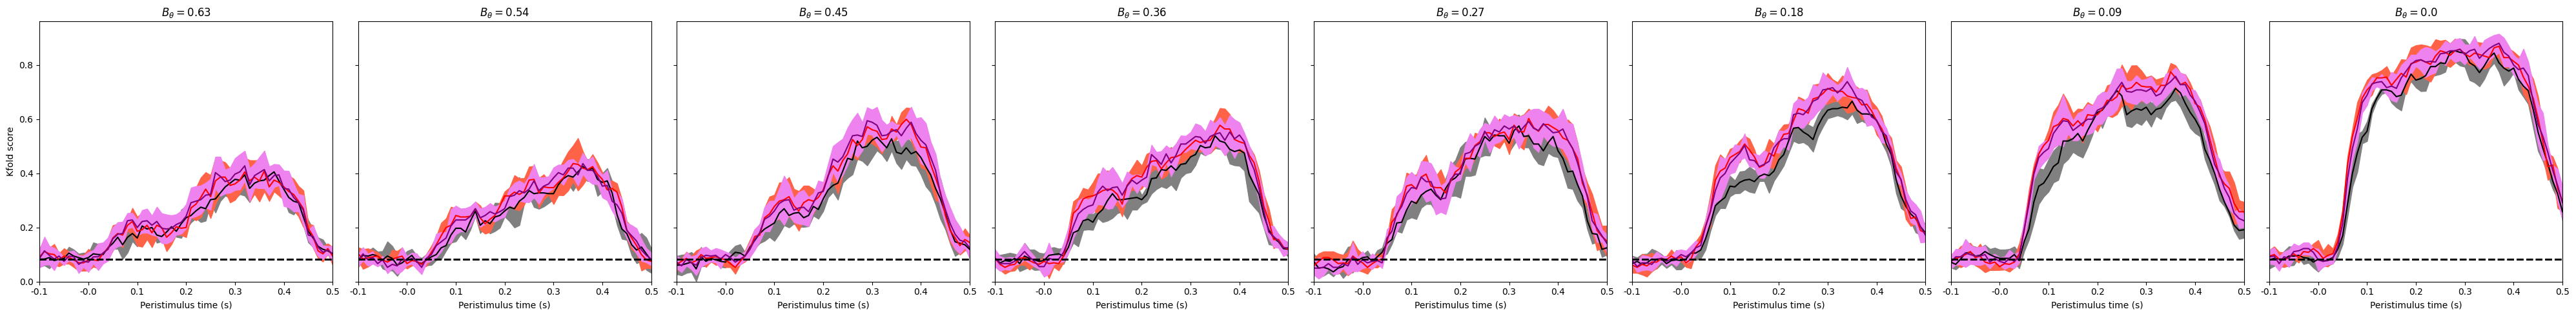

In [5]:
# Représentation graphique
fig,ax = plt.subplots(ncols=len(p.B_thetas), nrows=1, figsize=(5*len(p.B_thetas),5),
                      sharex=True, sharey=True)
for i,transfo_type in enumerate(transformation_type):
    for j in range(len(p.B_thetas)):
        ax[j].set_title(r"$B_\theta = $"+str(round(p.B_thetas[j],2)))
        ax[j].fill_between(p.timesteps,
                           Score_decod_theta[:,j,i,0]-Score_decod_theta[:,j,i,1],
                           Score_decod_theta[:,j,i,0]+Score_decod_theta[:,j,i,1],
                           color=colors_fill[i])
        ax[j].plot(p.timesteps, Score_decod_theta[:,j,i,0], color=colors[i])
        ax[j].hlines(y=1/12, xmin=p.timesteps.min(), xmax=p.timesteps.max(),
                     color="black", linestyle="dashed", linewidth=2)
        ax[j].set_xticks(p.timesteps[::10],
                        [round(x,1) for x in np.linspace(-0.1, 0.5, len(p.timesteps[::10]))])
        ax[j].set_xlabel("Peristimulus time (s)")
ax[0].set_xlim(p.timesteps[0], p.timesteps[-1])
ax[0].set_ylim(0)
ax[0].set_ylabel("Kfold score")
plt.tight_layout()
plt.show()

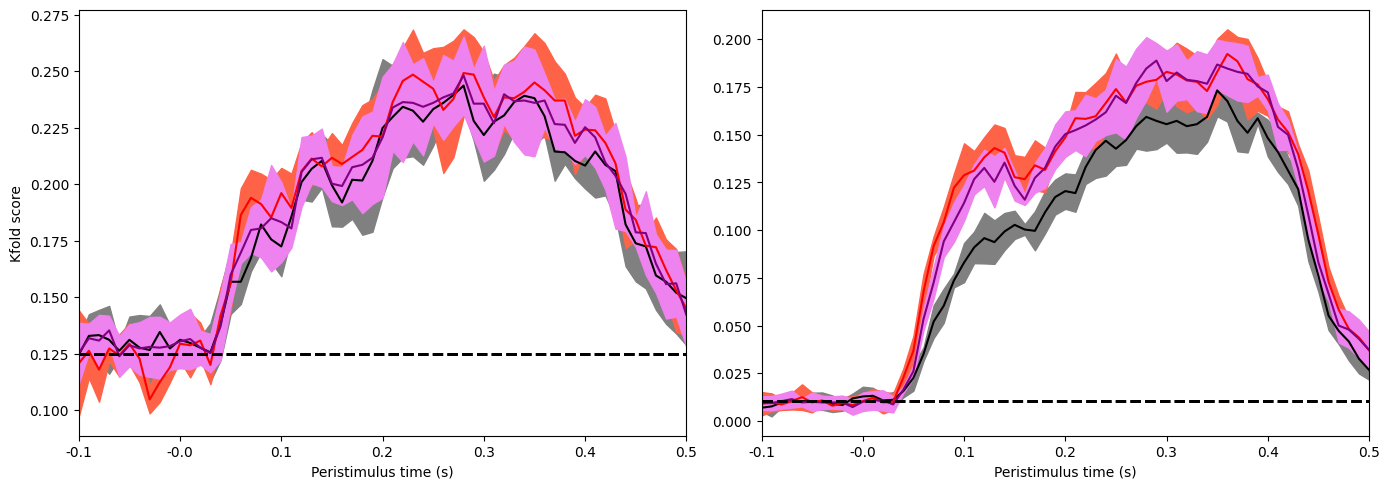

In [6]:
# Représentation graphique
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(7*2,5),
                      sharex=True, sharey=False)
for i,transfo_type in enumerate(transformation_type):
    ax[0].fill_between(p.timesteps,
                       Score_decod_btheta[:,i,0]-Score_decod_btheta[:,i,1],
                       Score_decod_btheta[:,i,0]+Score_decod_btheta[:,i,1],
                       color=colors_fill[i])
    ax[0].plot(p.timesteps, Score_decod_btheta[:,i,0], color=colors[i])
    ax[0].hlines(y=1/8, xmin=p.timesteps.min(), xmax=p.timesteps.max(),
                 color="black", linestyle="dashed", linewidth=2)
    ax[0].set_xticks(p.timesteps[::10], 
                     [round(x,1) for x in np.linspace(-0.1, 0.5, len(p.timesteps[::10]))])
    ax[0].set_xlabel("Peristimulus time (s)")

    ax[1].fill_between(p.timesteps,
                       Score_decod_combinaison[:,i,0]-Score_decod_combinaison[:,i,1],
                       Score_decod_combinaison[:,i,0]+Score_decod_combinaison[:,i,1],
                       color=colors_fill[i])
    ax[1].plot(p.timesteps, Score_decod_combinaison[:,i,0], color=colors[i])
    ax[1].hlines(y=1/96, xmin=p.timesteps.min(), xmax=p.timesteps.max(),
                 color="black", linestyle="dashed", linewidth=2)
    ax[1].set_xticks(p.timesteps[::10], 
                     [round(x,1) for x in np.linspace(-0.1, 0.5, len(p.timesteps[::10]))])
    ax[1].set_xlabel("Peristimulus time (s)")

ax[0].set_xlim(p.timesteps[0], p.timesteps[-1])
ax[0].set_ylabel("Kfold score")
plt.tight_layout()
plt.show()

## Analyse des résultats par le logg odd ratio
Pour analyser ces résultats et notamment pour les comparer, on passe par le calcul du `log odd ratio` ($e$). Il se calcul par la formule suivante :
$$ e = \log_2{\frac{p_i}{1-p_i}} $$
Nous donnant par conséquent une différence ($\Delta e$) selon la formulke suivante :
$$ \Delta e = \log_2{\frac{p_1}{1-p_1}} - \log_2{\frac{p_2}{1-p_2}} = \log{\frac{\frac{p_1}{1-p_1}}{\frac{p_2}{1-p_2}}}

In [7]:
# Fonction calculant les log odd ratio
def evid(data=[]):
    evidence = np.log2((data)/(1-data))
    return evidence

# Fonction faisant une régression linéaire
def lineareg(x=[], y=[]):
    xy = np.linspace(np.min(x), np.max(x), len(p.timesteps))
    model = lm(n_jobs=-1,).fit(x.reshape(-1, 1),
                     y.reshape(-1, 1))
    y = model.predict(xy.reshape(-1,1))
    return y.T[0], model.coef_

In [8]:
# Calcul des evidence mathématiques
### Décodage de theta
evidence_theta = np.zeros_like(Score_decod_theta)

for i,transfo_type in enumerate(transformation_type):
    for j,orientation in enumerate(p.B_thetas):
        evidence_theta[:,j,i,0] = evid(data=Score_decod_theta[:,j,i,0])

### Décodage de btheta et de la combinaison
evidence_combinaison = np.zeros_like(Score_decod_combinaison)
evidence_btheta = np.zeros_like(Score_decod_btheta)

for i,transfo_type in enumerate(transformation_type):
    evidence_combinaison[:,i,0] = evid(data=Score_decod_combinaison[:,i,0])
    evidence_btheta[:,i,0] = evid(data=Score_decod_btheta[:,i,0])

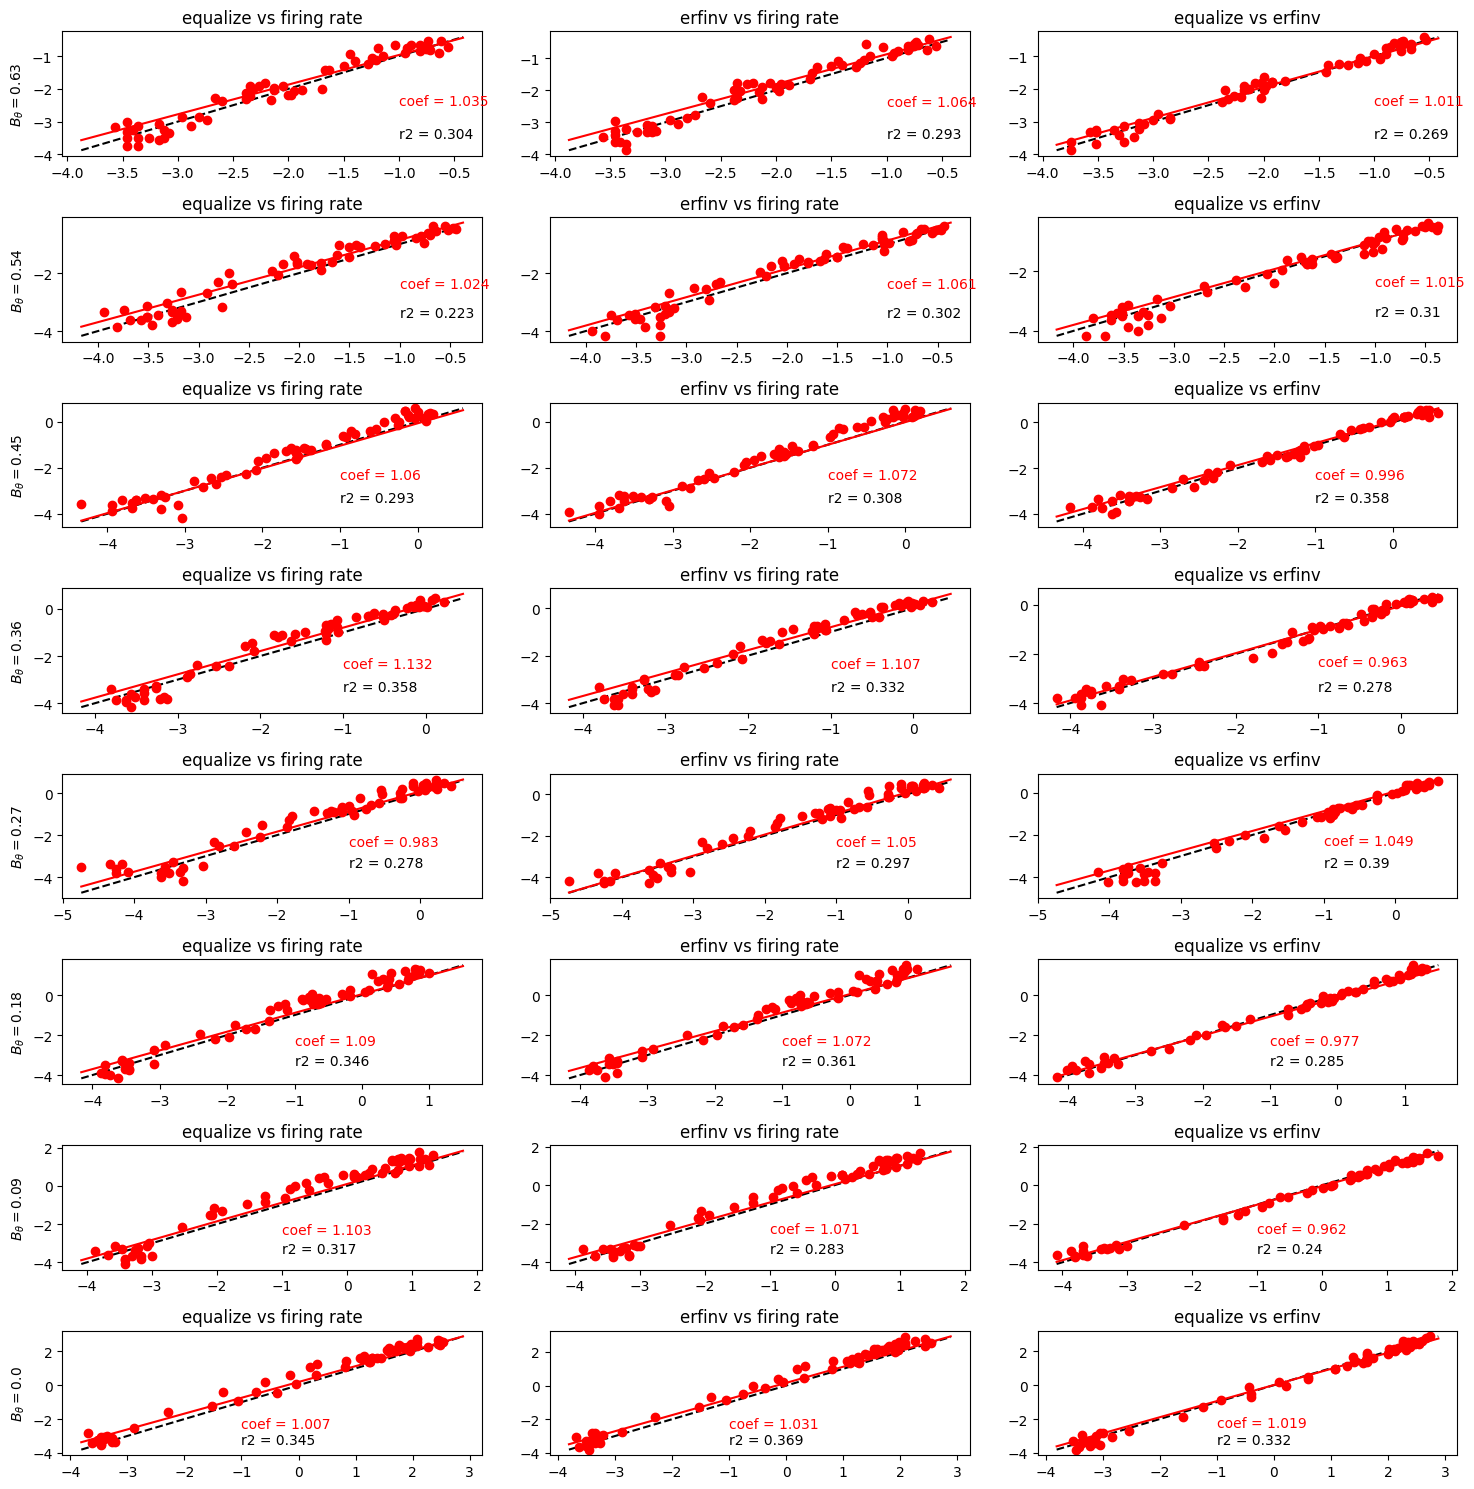

In [9]:
# Représentation d'un type vs un autre
fig, ax = plt.subplots(len(p.B_thetas), 3, figsize=(15,15))

for j in range(len(p.B_thetas)):
    xy = np.linspace(np.min(evidence_theta[:,j,:,0]),np.max(evidence_theta[:,j,:,0]),len(p.timesteps))
    for i in range(3):
        ax[j,i].plot(xy, xy, linestyle="dashed", color="black")
    ax[j,0].set_title("equalize vs firing rate")
    ax[j,0].plot(evidence_theta[:,j,0,0], evidence_theta[:,j,1,0], "o", color="red")
    Y, coef = lineareg(x=evidence_theta[:,j,0,0], y=evidence_theta[:,j,1,0])
    ax[j,0].text(x=-1, y=-2.5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
    ax[j,0].text(x=-1, y=-3.5, s=f"r2 = {np.round(r2(y_true=evidence_theta[:,j,1,0], y_pred=Y),3)}")
    ax[j,0].plot(xy,Y, color="red")
    

    ax[j,1].set_title("erfinv vs firing rate")
    ax[j,1].plot(evidence_theta[:,j,0,0], evidence_theta[:,j,2,0], "o", color="red")
    Y, coef = lineareg(x=evidence_theta[:,j,0,0], y=evidence_theta[:,j,2,0])
    ax[j,1].text(x=-1, y=-2.5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
    ax[j,1].text(x=-1, y=-3.5, s=f"r2 = {np.round(r2(y_true=evidence_theta[:,j,2,0], y_pred=Y),3)}")
    ax[j,1].plot(xy,Y, color="red")

    ax[j,2].set_title("equalize vs erfinv")
    ax[j,2].plot(evidence_theta[:,j,1,0], evidence_theta[:,j,2,0], "o", color="red")
    Y, coef = lineareg(x=evidence_theta[:,j,1,0], y=evidence_theta[:,j,2,0])
    ax[j,2].text(x=-1, y=-2.5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
    ax[j,2].text(x=-1, y=-3.5, s=f"r2 = {np.round(r2(y_true=evidence_theta[:,j,2,0], y_pred=Y),3)}")
    ax[j,2].plot(xy,Y, color="red")

    ax[j,0].set_ylabel(r"$B_{\theta} = $"+str(np.round(p.B_thetas[j], 2)))
plt.tight_layout()
plt.show()

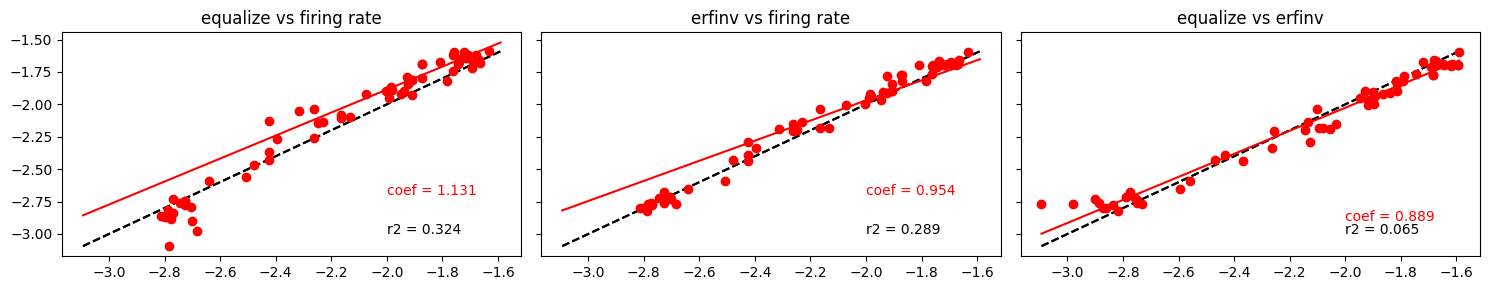

In [10]:
# Représentation d'un type vs un autre
fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True, sharey=True)

xy = np.linspace(np.min(evidence_btheta[:,:,0]),np.max(evidence_btheta[:,:,0]),len(p.timesteps))
for i in range(3):
    ax[i].plot(xy, xy, linestyle="dashed", color="black")

ax[0].plot(xy, xy, linestyle="dashed", color="black")
ax[0].set_title("equalize vs firing rate")
ax[0].plot(evidence_btheta[:,0,0], evidence_btheta[:,1,0],  "o", color="red")
Y, coef = lineareg(x=evidence_btheta[:,0,0], y=evidence_btheta[:,1,0])
ax[0].text(x=-2, y=-2.7, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[0].text(x=-2, y=-3, s=f"r2 = {np.round(r2(y_true=evidence_btheta[:,1,0], y_pred=Y),3)}")
ax[0].plot(xy,Y, color="red")

ax[1].plot(xy, xy, linestyle="dashed", color="black")
ax[1].set_title("erfinv vs firing rate")
ax[1].plot(evidence_btheta[:,0,0], evidence_btheta[:,2,0], "o", color="red")
Y, coef = lineareg(x=evidence_btheta[:,2,0], y=evidence_btheta[:,0,0])
ax[1].text(x=-2, y=-2.7, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[1].text(x=-2, y=-3, s=f"r2 = {np.round(r2(y_true=evidence_btheta[:,2,0], y_pred=Y),3)}")
ax[1].plot(xy,Y, color="red")

ax[2].plot(xy, xy, linestyle="dashed", color="black")
ax[2].set_title("equalize vs erfinv")
ax[2].plot(evidence_btheta[:,1,0], evidence_btheta[:,2,0], "o", color="red")
Y, coef = lineareg(x=evidence_btheta[:,1,0], y=evidence_btheta[:,2,0])
ax[2].text(x=-2, y=-2.9, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[2].text(x=-2, y=-3, s=f"r2 = {np.round(r2(y_true=evidence_btheta[:,2,0], y_pred=Y),3)}")
ax[2].plot(xy,Y, color="red")

plt.tight_layout()
plt.show()

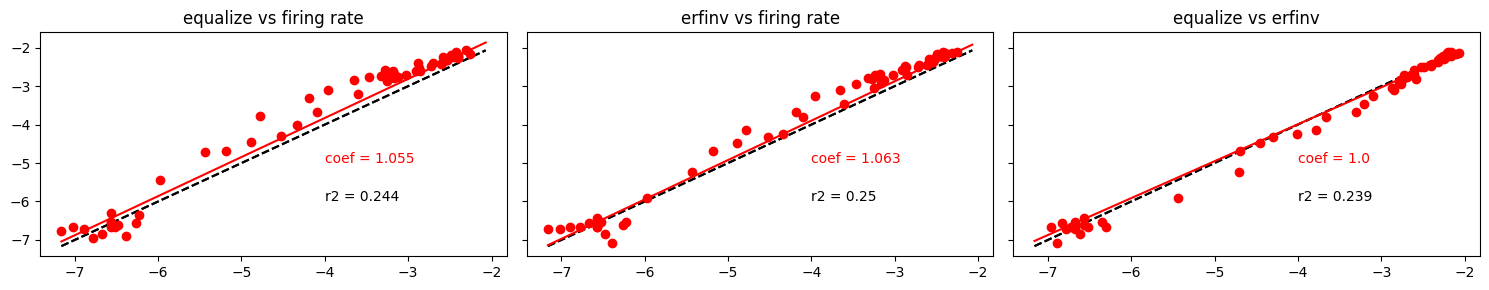

In [11]:
# Représentation d'un type vs un autre
fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True, sharey=True)

xy = np.linspace(np.min(evidence_combinaison[:,:,0]), np.max(evidence_combinaison[:,:,0]), len(p.timesteps))
for i in range(3):
    ax[i].plot(xy, xy, linestyle="dashed", color="black")

ax[0].plot(xy, xy, linestyle="dashed", color="black")
ax[0].set_title("equalize vs firing rate")
ax[0].plot(evidence_combinaison[:,0,0], evidence_combinaison[:,1,0], "o", color="red")
Y, coef = lineareg(x=evidence_combinaison[:,0,0], y=evidence_combinaison[:,1,0])
ax[0].text(x=-4, y=-5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[0].text(x=-4, y=-6, s=f"r2 = {np.round(r2(y_true=evidence_combinaison[:,1,0], y_pred=Y),3)}")
ax[0].plot(xy,Y, color="red")

ax[1].plot(xy, xy, linestyle="dashed", color="black")
ax[1].set_title("erfinv vs firing rate")
ax[1].plot(evidence_combinaison[:,0,0], evidence_combinaison[:,2,0], "o", color="red")
Y, coef = lineareg(x=evidence_combinaison[:,0,0], y=evidence_combinaison[:,2,0])
ax[1].text(x=-4, y=-5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[1].text(x=-4, y=-6, s=f"r2 = {np.round(r2(y_true=evidence_combinaison[:,2,0], y_pred=Y),3)}")
ax[1].plot(xy,Y, color="red")

ax[2].plot(xy, xy, linestyle="dashed", color="black")
ax[2].set_title("equalize vs erfinv")
ax[2].plot(evidence_combinaison[:,1,0], evidence_combinaison[:,2,0], "o", color="red")
Y, coef = lineareg(x=evidence_combinaison[:,1,0], y=evidence_combinaison[:,2,0])
ax[2].text(x=-4, y=-5, s=f"coef = {np.round(coef[0][0],3)}", color="red")
ax[2].text(x=-4, y=-6, s=f"r2 = {np.round(r2(y_true=evidence_combinaison[:,2,0], y_pred=Y),3)}")
ax[2].plot(xy,Y, color="red")
  

plt.tight_layout()
plt.show()

## Représentation temporelle du log odd ratio

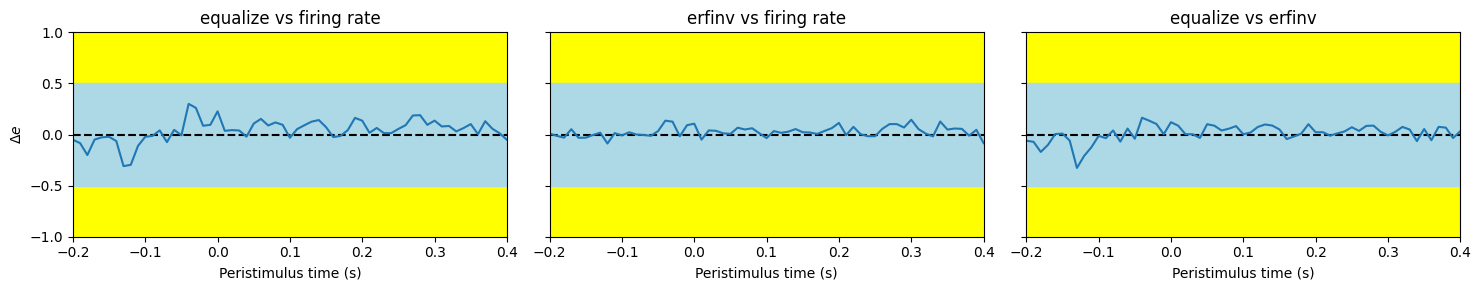

In [12]:
# Identification de la variabilité
fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True, sharey=True)
for i in range(3):
    ax[i].hlines(y=0, xmin=p.timesteps[0], xmax=p.timesteps[-1],
                 linestyle="dashed", color="black")
    ax[i].set_xlabel("Peristimulus time (s)")
    ax[i].fill_between(p.timesteps, -1, 1, color='yellow')
    ax[i].fill_between(p.timesteps, -0.5, 0.5, color='lightblue')
ax[0].plot(p.timesteps,
           evidence_btheta[:,1,0]-evidence_btheta[:,0,0])
ax[0].set_title("equalize vs firing rate")
ax[1].plot(p.timesteps,
           evidence_btheta[:,2,0]-evidence_btheta[:,0,0])
ax[1].set_title("erfinv vs firing rate")
ax[2].plot(p.timesteps,
           evidence_btheta[:,1,0]-evidence_btheta[:,2,0])
ax[2].set_title("equalize vs erfinv")
ax[0].set_xlim(p.timesteps[0], p.timesteps[-1])
ax[0].set_ylabel(r"$\Delta e$")
ax[0].set_ylim(-1,1)
plt.tight_layout()
plt.show()


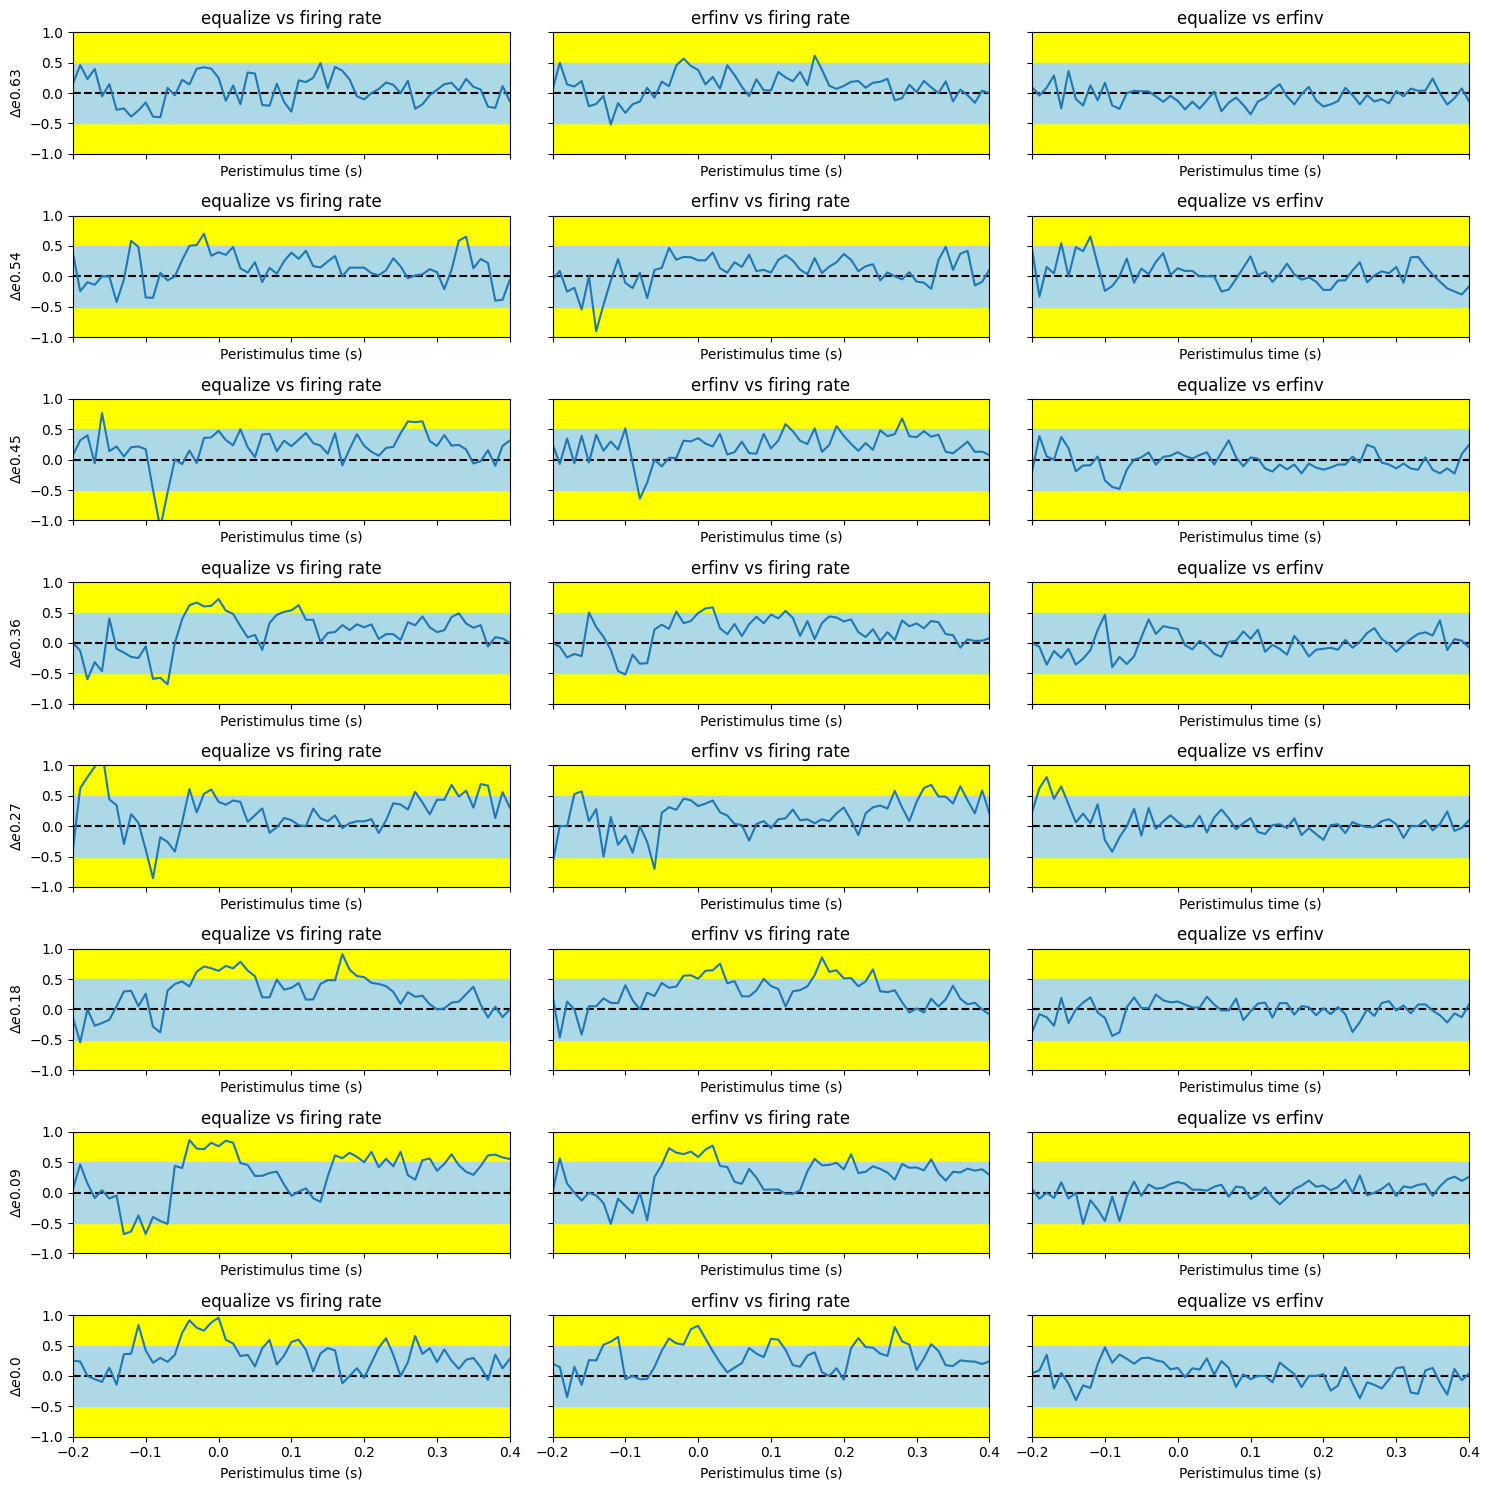

In [13]:
# Représentation d'un type vs un autre
fig, ax = plt.subplots(len(p.B_thetas), 3, figsize=(15,15), sharex=True, sharey=True)
for j in range(len(p.B_thetas)):
    for i in range(3):
        ax[j,i].hlines(y=0, xmin=p.timesteps[0], xmax=p.timesteps[-1],
                     linestyle="dashed", color="black")
        ax[j,i].set_xlabel("Peristimulus time (s)")
        ax[j,i].fill_between(p.timesteps, -1, 1, color='yellow')
        ax[j,i].fill_between(p.timesteps, -0.5, 0.5, color='lightblue')
        ax[j,i].set_ylim(-1,1)
    ax[j,0].plot(p.timesteps,
               evidence_theta[:,j,1,0]-evidence_theta[:,j,0,0])
    ax[j,0].set_title("equalize vs firing rate")
    ax[j,1].plot(p.timesteps,
               evidence_theta[:,j,2,0]-evidence_theta[:,j,0,0])
    ax[j,1].set_title("erfinv vs firing rate")
    ax[j,2].plot(p.timesteps,
               evidence_theta[:,j,1,0]-evidence_theta[:,j,2,0])
    ax[j,2].set_title("equalize vs erfinv")
    ax[j,0].set_xlim(p.timesteps[0], p.timesteps[-1])
    ax[j,0].set_ylabel(r"$\Delta e$"+f"{np.round(p.B_thetas[j],2)}")
fig.axes.reverse()
plt.tight_layout()
plt.show()

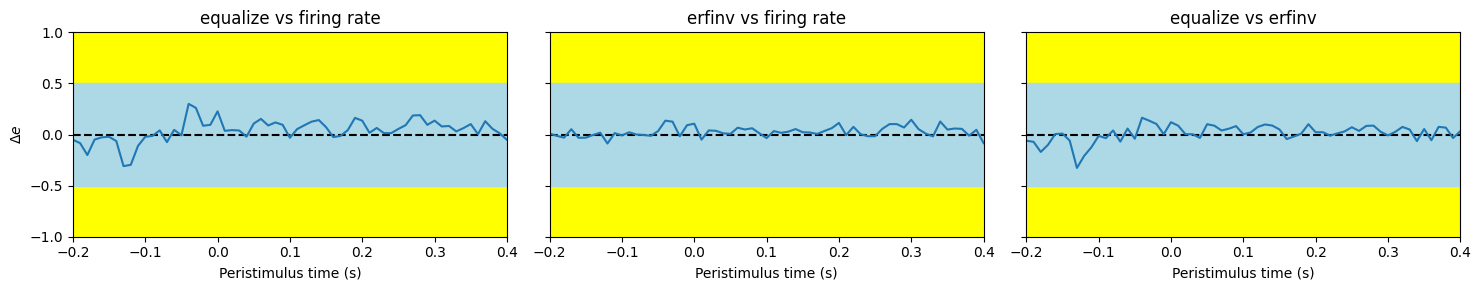

In [14]:
# Identification de la variabilité
fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True, sharey=True)
for i in range(3):
    ax[i].hlines(y=0, xmin=p.timesteps[0], xmax=p.timesteps[-1],
                 linestyle="dashed", color="black")
    ax[i].set_xlabel("Peristimulus time (s)")
    ax[i].fill_between(p.timesteps, -1, 1, color='yellow')
    ax[i].fill_between(p.timesteps, -0.5, 0.5, color='lightblue')
ax[0].plot(p.timesteps,
           evidence_btheta[:,1,0]-evidence_btheta[:,0,0])
ax[0].set_title("equalize vs firing rate")
ax[1].plot(p.timesteps,
           evidence_btheta[:,2,0]-evidence_btheta[:,0,0])
ax[1].set_title("erfinv vs firing rate")
ax[2].plot(p.timesteps,
           evidence_btheta[:,1,0]-evidence_btheta[:,2,0])
ax[2].set_title("equalize vs erfinv")
ax[0].set_xlim(p.timesteps[0], p.timesteps[-1])
ax[0].set_ylabel(r"$\Delta e$")
ax[0].set_ylim(-1,1)
plt.tight_layout()
plt.show()


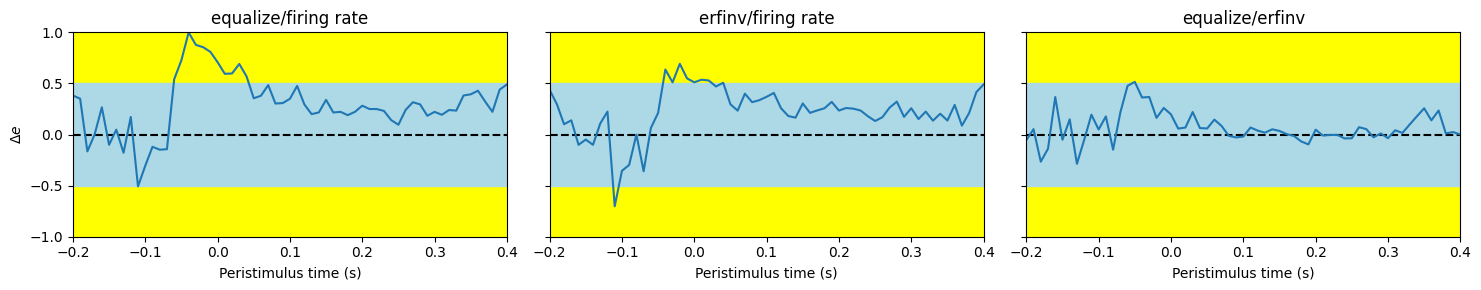

In [15]:
# Identification de la combinaison
fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True, sharey=True)
for i in range(3):
    ax[i].hlines(y=0, xmin=p.timesteps[0], xmax=p.timesteps[-1],
                 linestyle="dashed", color="black")
    ax[i].set_xlabel("Peristimulus time (s)")
    ax[i].fill_between(p.timesteps, -1, 1, color='yellow')
    ax[i].fill_between(p.timesteps, -0.5, 0.5, color='lightblue')
ax[0].plot(p.timesteps,
           evidence_combinaison[:,1,0]-evidence_combinaison[:,0,0])
ax[0].set_title("equalize/firing rate")
ax[1].plot(p.timesteps,
           evidence_combinaison[:,2,0]-evidence_combinaison[:,0,0])
ax[1].set_title("erfinv/firing rate")
ax[2].plot(p.timesteps,
           evidence_combinaison[:,1,0]-evidence_combinaison[:,2,0])
ax[2].set_title("equalize/erfinv")
ax[0].set_xlim(p.timesteps[0], p.timesteps[-1])
ax[0].set_ylim(-1,1)
ax[0].set_ylabel(r"$\Delta e$")
plt.tight_layout()
plt.show()


# Autres représentations

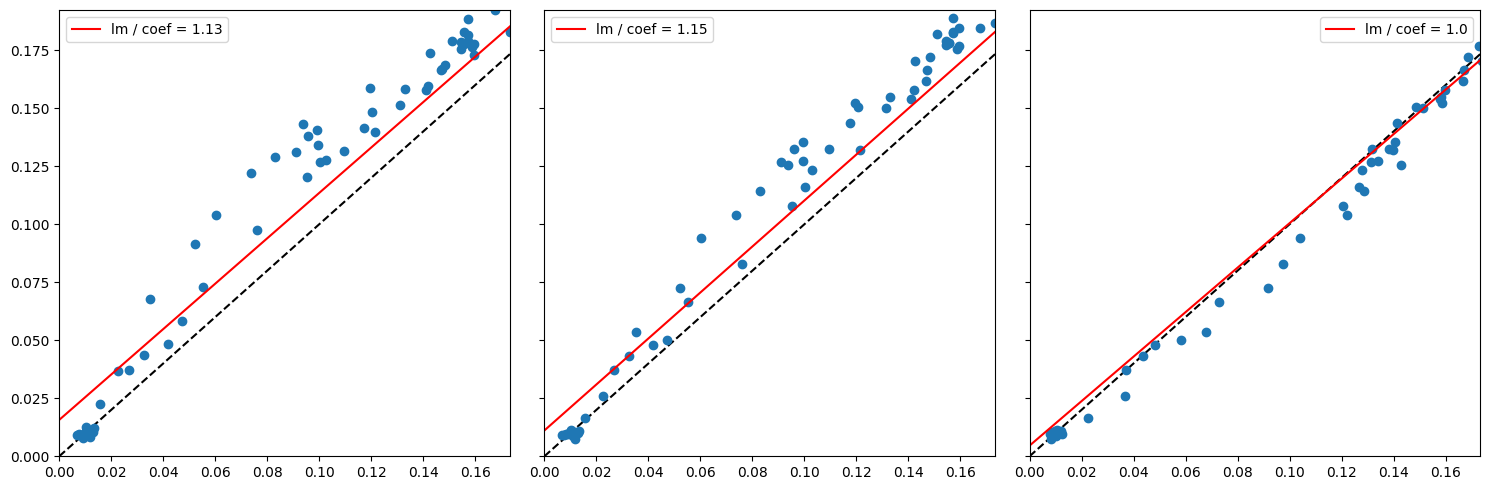

In [29]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

xy = np.linspace(0, np.max(Score_decod_combinaison[:,:,0]), len(p.timesteps))
for i in range(3):
    ax[i].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black")

ax[0].plot(Score_decod_combinaison[:,0,0], Score_decod_combinaison[:,1,0], "o")
Y, coef = lineareg(x=Score_decod_combinaison[:,0,0], y=Score_decod_combinaison[:,1,0])
ax[0].plot(xy, Y, color="red", label=f"lm / coef = {round(coef[0][0],2)}")
ax[0].legend()

ax[1].plot(Score_decod_combinaison[:,0,0], Score_decod_combinaison[:,2,0], "o")
Y, coef = lineareg(x=Score_decod_combinaison[:,0,0], y=Score_decod_combinaison[:,2,0])
ax[1].plot(xy, Y, color="red", label=f"lm / coef = {round(coef[0][0],2)}")
ax[1].legend()

ax[2].plot(Score_decod_combinaison[:,1,0], Score_decod_combinaison[:,2,0], "o")
Y, coef = lineareg(x=Score_decod_combinaison[:,1,0], y=Score_decod_combinaison[:,2,0])
ax[2].plot(xy, Y, color="red", label=f"lm / coef = {round(coef[0][0],2)}")
ax[2].legend()

ax[1].set_xlim(0, np.max(Score_decod_combinaison[:,0,0]))
ax[1].set_ylim(0,np.max([Score_decod_combinaison[:,1,0],Score_decod_combinaison[:,2,0]]))
plt.tight_layout()
plt.show()